# ROC-AUC ANALYSIS 

by __Pawel Rosikiewicz__ 

---

## Setup
---

In [2]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [4]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

__load imports functions, and classes created for that project__

In [5]:
# classifiers used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# pipeline and model selection
from sklearn import set_config
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.decomposition import PCA

# feature transformations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers
from sklearn.preprocessing import RobustScaler # creates custom transfomers

# stats
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# my custom fucntions, 
from src.utils.helper_data_loaders import load_tsv
from sklearn.metrics import classification_report
from src.utils.helper_merge_dfs import merge_data
from src.utils.Model_Evaluation_PIPELINE   import train_and_evaluate_models
from src.utils.Model_Evaluation_TOOLS import *

In [6]:
from src.utils.FastClassAI_model_summary_tools import model_summary_plot # legacy function, from 2 years ago, on 
from src.utils.Model_Summary_TOOLS import load_predictions_and_stats 
from src.utils.Model_Summary_TOOLS import modify_model_statistics_df
from src.utils.Model_Summary_TOOLS import create_group_top_model_list
from src.utils.Model_Summary_TOOLS import modified_model_stats_and_plot_ROC_curves
from src.utils.Model_Summary_TOOLS import play_with_rocks
from src.utils.Model_Summary_TOOLS import * # to be sure

## DATA PREPARATION
* because there were only ~300 samples in total, I will load and organize the results generated in notebook 04 at once, and work on these data

## Load the data

In [7]:
# params
path = PATH_data_interim
model_name_list = ["knn", "logreg", "random_forest", "svc"] 

# extraxt data
model_statistics_df, model_predictions_valid, model_predictions_test = load_predictions_and_stats(
    PATH_data_interim, model_name_list, verbose=True)

# reset index
model_statistics_df.reset_index(inplace=True, drop=True)

loading_df 0 knn__model_statistics_df.p shape_total: (1008, 16)
loading_df 1 logreg__model_statistics_df.p shape_total: (1368, 16)
loading_df 2 random_forest__model_statistics_df.p shape_total: (1692, 16)
loading_df 3 svc__model_statistics_df.p shape_total: (2556, 16)
loading_df 0 knn__model_predictions_list.p shape_total: 1008
loading_df 1 logreg__model_predictions_list.p shape_total: 1368
loading_df 2 random_forest__model_predictions_list.p shape_total: 1692
loading_df 3 svc__model_predictions_list.p shape_total: 2556


## First look on all the models
__we will compare "ROC_AUC", "Presision", "Recall" from all models, to see what combinaiton of data preprocessing and models was able to generate the best models, on validations data__

__OBSERVATIONS__
* overall, the best performing model, were build with random forest algorithm, however these models, often sufferred with low precision and reacall, for less freqent class (1)  
* it is better to use larger number of genes, for making predicitons even if they 
eg models created wiht G2000 dataset, had consistenly higher ROC-auc then the models trains with G100, that contains from 885-150 differentially expressed genes, 
* interestingly, two datasets that generated the largest number of models with the highest values of ROC-AUC were treated very differently, 
    * P17_G2000_PCA, had only 150 features, with PCA done on scaled log(tpm) data
    * in contrast, P17_G2000_LOG, had over 2500 features, with log(tpm) data, 
    * Suggestion: I woould compare results provided with these two models, and if they are consistent, between reach other I wodul preffer using the model with smaller number of features for deployment, even if additional genes were providing noise to the data, 
    
 
    

In [8]:
model_statistics_df.columns

Index(['model_name', 'dataset_name', 'rand_nr', 'model_id', 'cond_id',
       'model_params', 'Acc_baseline', 'Acc', 'ROC_AUC', 'PRC_AUC', 'Recall',
       'Presision', 'F1', 'counts_y', 'counts_y_hat', 'tr'],
      dtype='object')

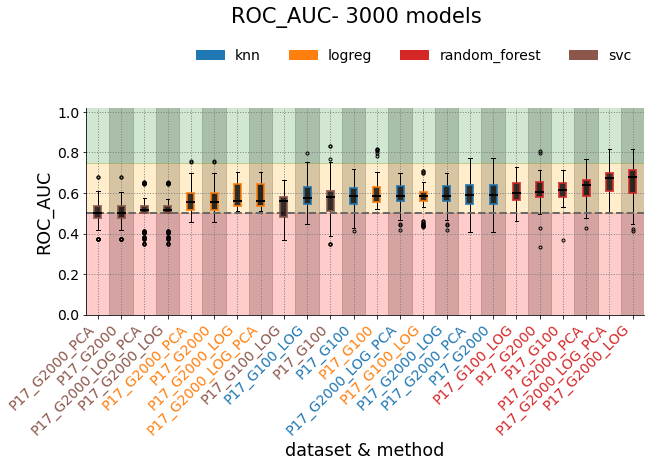

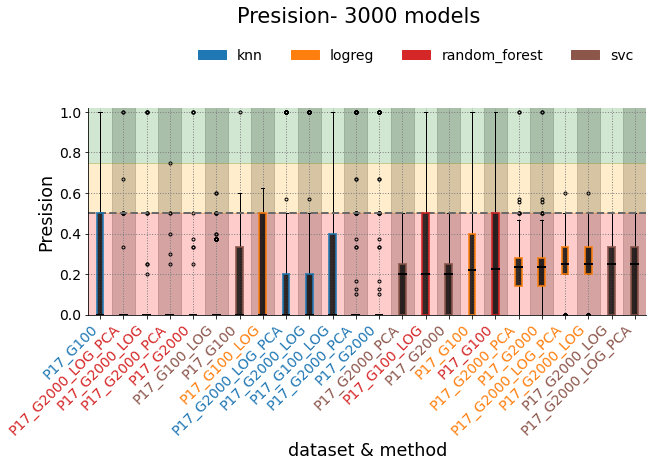

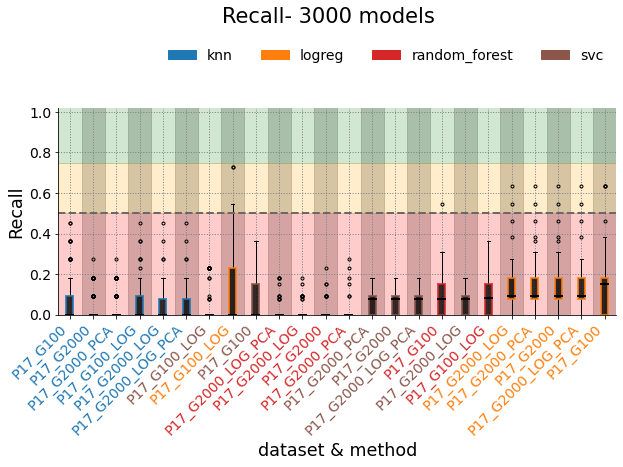

In [9]:
# to silence error on depreciated function, 
warnings.filterwarnings("ignore")

# plots stats from each group of models
for stat_type in ["ROC_AUC", "Presision", "Recall"]:
    # you can also look into "Acc", "F1"

    # boxplot, 
    fig = model_summary_plot(      
        title                  = f"{stat_type}- 3000 models",
        df                     = model_statistics_df,
        y                      = stat_type,
        boxname                = "dataset_name",
        boxcolor               = "model_name",
        scatterpoints          = None, #summary_df.run_name.str.contains("all_data").values.tolist(),
        baseline               = 0.5, #"baseline_acc_test",                                 
        figsize                = (10,5), 
        use_fixed_baselines    = True,
        baseline_limit_list    = [0.5, 0.75, 1.5], # upprer limits for bg colors
        legend__bbox_to_anchor = (0.9, 0.9),
        fontsize_scale         =  0.7,
        xaxis_label            = "dataset & method",
        yaxis_label            = stat_type, # if Noene == ydata_colname
        legend_ncols=4, 
        baseline_title='', 
        baseline_loc=-0.09, 


    )

    fig.show();

## see what exact models were best performing in each group of models,


### __SHOW 10 BEST PERFORMIN MODELS__

In [10]:
model_statistics_means = modify_model_statistics_df(model_statistics_df)
top10_models = model_statistics_means.sort_values("ROC_AUC", ascending=False).head(10)
display(top10_models)

model_name       dataset_name    ID  ROC_AUC  Presision  Recall  \
566            svc           P17_G100  1790    0.740      0.000   0.000   
578            svc           P17_G100  1802    0.736      0.111   0.030   
518  random_forest      P17_G2000_LOG  1628    0.733      0.000   0.000   
545  random_forest  P17_G2000_LOG_PCA  1691    0.727      0.000   0.000   
526  random_forest      P17_G2000_LOG  1636    0.724      0.000   0.000   
495  random_forest          P17_G2000  1461    0.718      0.000   0.000   
564            svc           P17_G100  1788    0.717      0.000   0.000   
536  random_forest  P17_G2000_LOG_PCA  1682    0.714      0.167   0.026   
543  random_forest  P17_G2000_LOG_PCA  1689    0.710      0.000   0.000   
550  random_forest      P17_G2000_PCA  1516    0.710      0.000   0.000   

        F1   tr        counts_y counts_y_hat  \
566  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
578  0.048  0.5  {0: 39, 1: 11}      {0: 50}   
518  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
545  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
526  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
495  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
564  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
536  0.044  0.5  {0: 39, 1: 11}      {0: 50}   
543  0.000  0.5  {0: 39, 1: 11}      {0: 50}   
550  0.000  0.5  {0: 39, 1: 11}      {0: 50}   

                                          model_params  
566        {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}  
578          {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}  
518  {'class_weight': 'balanced', 'max_depth': 5, '...  
545  {'class_weight': 'balanced', 'max_depth': 6, '...  
526  {'class_weight': 'balanced', 'max_depth': 6, '...  
495  {'class_weight': 'balanced', 'max_depth': 4, '...  
564       {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}  
536  {'class_weight': 'balanced', 'max_depth': 5, '...  
543  {'class_weight': 'balanced', 'max_depth': 6, '...  
550  {'class_weight': 'balanced', 'max_depth': 4, '...

### __SHOW 5 BEST PERFORMING MODELS CREATED WITH EACH METHOD__

In [11]:
top20_models = create_group_top_model_list(
    model_statistics_means, 
    order_models_by="ROC_AUC", 
    groupby="model_name", 
    n=5
)
display(top20_models.sort_values(by="ROC_AUC", ascending=False))

model_name       dataset_name    ID  ROC_AUC  Presision  Recall  \
566            svc           P17_G100  1790    0.740      0.000   0.000   
578            svc           P17_G100  1802    0.736      0.111   0.030   
518  random_forest      P17_G2000_LOG  1628    0.733      0.000   0.000   
545  random_forest  P17_G2000_LOG_PCA  1691    0.727      0.000   0.000   
526  random_forest      P17_G2000_LOG  1636    0.724      0.000   0.000   
495  random_forest          P17_G2000  1461    0.718      0.000   0.000   
564            svc           P17_G100  1788    0.717      0.000   0.000   
536  random_forest  P17_G2000_LOG_PCA  1682    0.714      0.167   0.026   
576            svc           P17_G100  1800    0.701      0.644   0.147   
568            svc           P17_G100  1792    0.689      0.000   0.000   
341         logreg           P17_G100  1053    0.666      0.778   0.086   
339         logreg           P17_G100  1051    0.666      0.167   0.030   
337         logreg           P17_G100  1049    0.664      0.000   0.000   
336         logreg           P17_G100  1048    0.662      0.338   0.427   
338         logreg           P17_G100  1050    0.660      0.339   0.401   
197            knn      P17_G2000_LOG   813    0.655      0.333   0.030   
313            knn      P17_G2000_PCA   481    0.655      0.000   0.000   
145            knn          P17_G2000   313    0.655      0.000   0.000   
253            knn  P17_G2000_LOG_PCA   981    0.655      0.333   0.030   
149            knn          P17_G2000   317    0.654      0.000   0.000   

        F1   tr        counts_y    counts_y_hat  \
566  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
578  0.048  0.5  {0: 39, 1: 11}         {0: 50}   
518  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
545  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
526  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
495  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
564  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
536  0.044  0.5  {0: 39, 1: 11}         {0: 50}   
576  0.220  0.5  {0: 39, 1: 11}   {0: 45, 1: 5}   
568  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
341  0.151  0.5  {0: 39, 1: 11}   {0: 49, 1: 1}   
339  0.051  0.5  {0: 39, 1: 11}         {0: 50}   
337  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
336  0.373  0.5  {0: 39, 1: 11}  {0: 34, 1: 16}   
338  0.363  0.5  {0: 39, 1: 11}  {0: 34, 1: 16}   
197  0.056  0.5  {0: 39, 1: 11}   {0: 49, 1: 1}   
313  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
145  0.000  0.5  {0: 39, 1: 11}         {0: 50}   
253  0.056  0.5  {0: 39, 1: 11}   {0: 49, 1: 1}   
149  0.000  0.5  {0: 39, 1: 11}         {0: 50}   

                                          model_params  
566        {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}  
578          {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}  
518  {'class_weight': 'balanced', 'max_depth': 5, '...  
545  {'class_weight': 'balanced', 'max_depth': 6, '...  
526  {'class_weight': 'balanced', 'max_depth': 6, '...  
495  {'class_weight': 'balanced', 'max_depth': 4, '...  
564       {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}  
536  {'class_weight': 'balanced', 'max_depth': 5, '...  
576         {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}  
568         {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}  
341  {'C': 0.005994842503189409, 'class_weight': No...  
339  {'C': 0.000774263682681127, 'class_weight': No...  
337  {'C': 0.0001, 'class_weight': None, 'penalty':...  
336  {'C': 0.0001, 'class_weight': 'balanced', 'pen...  
338  {'C': 0.000774263682681127, 'class_weight': 'b...  
197  {'n_neighbors': 16, 'p': 1, 'weights': 'distan...  
313  {'n_neighbors': 18, 'p': 1, 'weights': 'distan...  
145  {'n_neighbors': 18, 'p': 1, 'weights': 'distan...  
253  {'n_neighbors': 16, 'p': 1, 'weights': 'distan...  
149  {'n_neighbors': 20, 'p': 1, 'weights': 'distan...

### __see plots wiht ROC CURVES FOR top10 models__
* examine each model visually, 
* play with thresholds
* decide which model prediciton to deliver

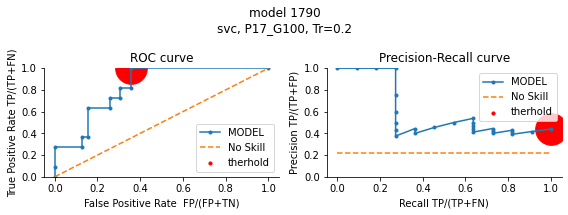

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC Recall Presision  \
0  None        svc     P17_G100         0.78  0.72  0.829837    1.0      0.44   

         F1   tr        counts_y    counts_y_hat  \
0  0.611111  0.2  {0: 39, 1: 11}  {0: 25, 1: 25}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.2 {0: 60, 1: 38}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




In [12]:
prediciton_test_adjusted = play_with_rocks(
    ID = 1790,
    threshold = 0.2,
    predictions_with_y = model_predictions_valid,
    predictions_without_y = model_predictions_test
    )

__Check the performance of the model under different thresholds__

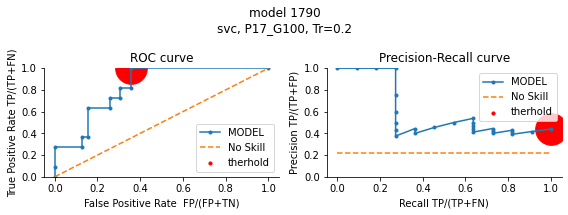

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC Recall Presision  \
0  None        svc     P17_G100         0.78  0.72  0.829837    1.0      0.44   

         F1   tr        counts_y    counts_y_hat  \
0  0.611111  0.2  {0: 39, 1: 11}  {0: 25, 1: 25}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.2 {0: 60, 1: 38}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




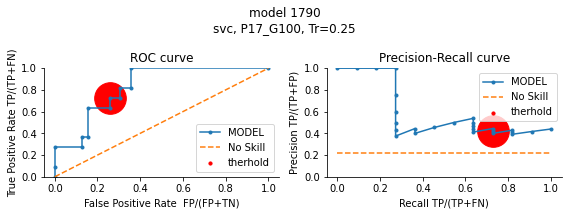

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.72  0.829837  0.727273   

  Presision        F1    tr        counts_y    counts_y_hat  \
0  0.421053  0.533333  0.25  {0: 39, 1: 11}  {0: 31, 1: 19}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.25 {0: 66, 1: 32}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




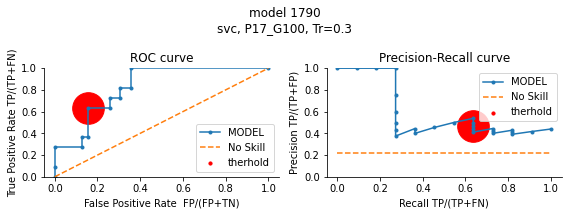

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.76  0.829837  0.636364   

  Presision        F1   tr        counts_y    counts_y_hat  \
0  0.466667  0.538462  0.3  {0: 39, 1: 11}  {0: 35, 1: 15}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.3 {0: 69, 1: 29}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




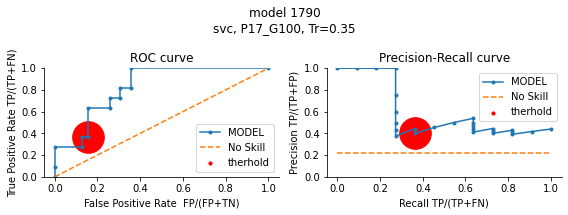

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.74  0.829837  0.363636   

  Presision        F1    tr        counts_y    counts_y_hat  \
0       0.4  0.380952  0.35  {0: 39, 1: 11}  {0: 40, 1: 10}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.35 {0: 72, 1: 26}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




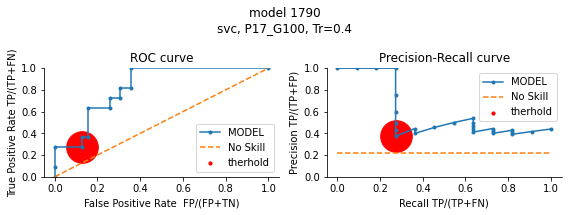

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.74  0.829837  0.272727   

  Presision        F1   tr        counts_y   counts_y_hat  \
0     0.375  0.315789  0.4  {0: 39, 1: 11}  {0: 42, 1: 8}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.4 {0: 74, 1: 24}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




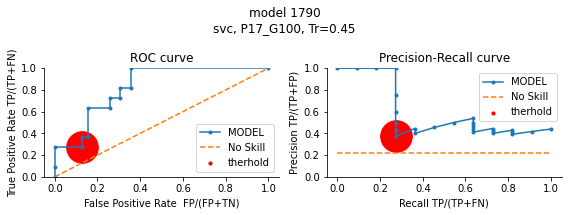

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.74  0.829837  0.272727   

  Presision        F1    tr        counts_y   counts_y_hat  \
0     0.375  0.315789  0.45  {0: 39, 1: 11}  {0: 42, 1: 8}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.45 {0: 81, 1: 17}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




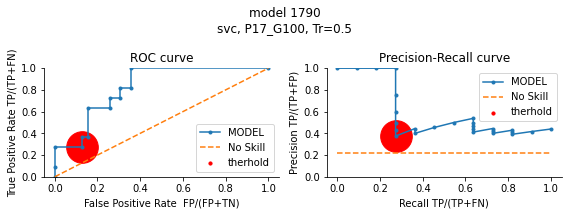

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC Recall Presision  \
0  None        svc     P17_G100         0.78  0.78  0.829837    0.0       0.0   

    F1   tr        counts_y counts_y_hat  \
0  0.0  0.5  {0: 39, 1: 11}      {0: 50}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.5 {0: 83, 1: 15}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




In [13]:
for tr in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    prediciton_test_adjusted = play_with_rocks(
        ID = 1790,
        threshold = tr,
        predictions_with_y = model_predictions_valid,
        predictions_without_y = model_predictions_test
        )

## PART 2 - SAVE PREDICITONS PROVIDED WITH THE BEST PERFORMING MODEL
---

__The model__
* despite svm model ID 1790 had the highest ROC-AUC, the other model build with random forest alg. provides better treadoff in detecting good responders to treatment, 
* from that reason, I will use model with ID 1636 to provide predictions on test data

__Threshold adjustment__
* after testing sever different thresholds, I found tr=0.3, as providing the best tread-off between Specificity and Sensitivity,
* below you can see QC report


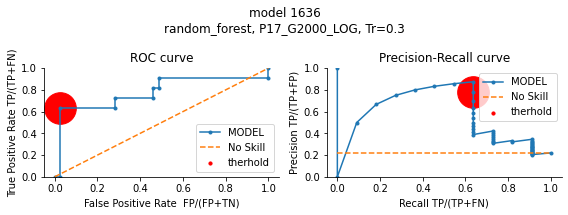

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name   dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None  random_forest  P17_G2000_LOG         0.78  0.88  0.780886  0.636364   

  Presision   F1   tr        counts_y   counts_y_hat  \
0  0.777778  0.7  0.3  {0: 39, 1: 11}  {0: 41, 1: 9}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 6, '...

...............................................................................................
Test Data: tr=0.5: {0: 97, 1: 1}
Test Data: tr=0.3 {0: 73, 1: 25}
...............................................................................................


'Available roc thresholds'

array([0.426, 0.306, 0.259, 0.258, 0.236, 0.231, 0.229, 0.223, 0.152,
       0.144])

-------------------------------------------------------------------------------------------




In [16]:

# setting
model_ID = 1636
Optimal_Threshold = 0.3
path = PATH_results

prediciton_test_adjusted = play_with_rocks(
    ID = model_ID,
    threshold = 0.3,
    predictions_with_y = model_predictions_valid,
    predictions_without_y = model_predictions_test
    )


In [19]:
# check the file
prediciton_test_adjusted.head()

y_hat y_hat_probs  trhreshold
0      0    0.261419         0.3
1      0    0.263254         0.3
2      1    0.323111         0.3
3      0     0.19408         0.3
4      0    0.247661         0.3

In [21]:
os.chdir(PATH_results)
%ls
%pwd

predictions.tsv


'/Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/results'

In [28]:
# save file
print(prediciton_test_adjusted.shape)
prediciton_test_adjusted.to_csv('predictions.tsv',  encoding = 'utf-8', index = False, sep="\t")

(98, 3)


In [29]:
# load file to test if everythign is ok
df_test = pd.read_csv('predictions.tsv', sep="\t")
print(df_test.shape)

(98, 3)


In [30]:
df_test.head()

y_hat  y_hat_probs  trhreshold
0      0     0.261419         0.3
1      0     0.263254         0.3
2      1     0.323111         0.3
3      0     0.194080         0.3
4      0     0.247661         0.3

## __For compariosn I provide reports from all other top10 models__
---

__Now lest see ROC cusrves for all top 10 models__

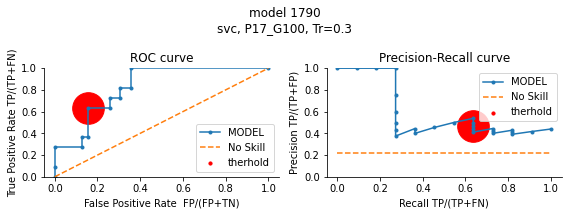

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.76  0.829837  0.636364   

  Presision        F1   tr        counts_y    counts_y_hat  \
0  0.466667  0.538462  0.3  {0: 39, 1: 11}  {0: 35, 1: 15}   

                                  model_params  
0  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.3 {0: 69, 1: 29}
...............................................................................................


'Available roc thresholds'

array([0.912, 0.734, 0.526, 0.383, 0.359, 0.318, 0.263, 0.262, 0.237,
       0.228, 0.209, 0.2  , 0.034])

-------------------------------------------------------------------------------------------




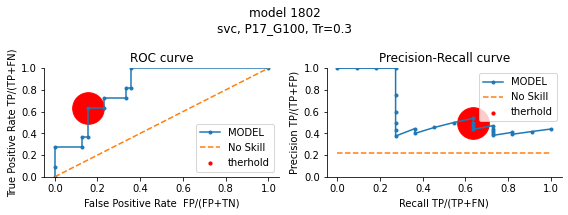

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.78  0.829837  0.636364   

  Presision    F1   tr        counts_y    counts_y_hat  \
0       0.5  0.56  0.3  {0: 39, 1: 11}  {0: 36, 1: 14}   

                                model_params  
0  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.3 {0: 69, 1: 29}
...............................................................................................


'Available roc thresholds'

array([0.888, 0.698, 0.5  , 0.374, 0.347, 0.312, 0.284, 0.263, 0.227,
       0.227, 0.208, 0.201, 0.041])

-------------------------------------------------------------------------------------------




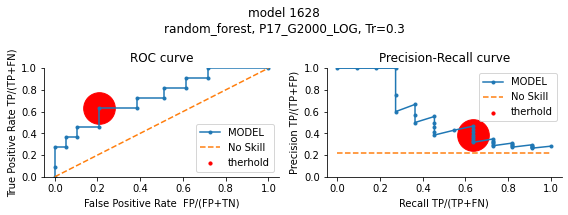

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name   dataset_name Acc_baseline  Acc   ROC_AUC    Recall  \
0  None  random_forest  P17_G2000_LOG         0.78  0.7  0.745921  0.636364   

  Presision        F1   tr        counts_y    counts_y_hat  \
0  0.388889  0.482759  0.3  {0: 39, 1: 11}  {0: 32, 1: 18}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 5, '...

...............................................................................................
Test Data: tr=0.5: {0: 95, 1: 3}
Test Data: tr=0.3 {0: 60, 1: 38}
...............................................................................................


'Available roc thresholds'

array([0.464, 0.431, 0.403, 0.402, 0.362, 0.362, 0.318, 0.313, 0.275,
       0.272, 0.254, 0.251, 0.237, 0.236, 0.204, 0.198, 0.08 ])

-------------------------------------------------------------------------------------------




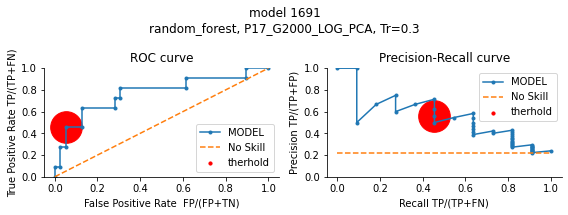

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name       dataset_name Acc_baseline  Acc   ROC_AUC  \
0  None  random_forest  P17_G2000_LOG_PCA         0.78  0.8  0.771562   

     Recall Presision   F1   tr        counts_y   counts_y_hat  \
0  0.454545  0.555556  0.5  0.3  {0: 39, 1: 11}  {0: 41, 1: 9}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 6, '...

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.3 {0: 80, 1: 18}
...............................................................................................


'Available roc thresholds'

array([0.391, 0.389, 0.337, 0.322, 0.305, 0.298, 0.289, 0.258, 0.258,
       0.255, 0.253, 0.21 , 0.208, 0.168, 0.162, 0.111])

-------------------------------------------------------------------------------------------




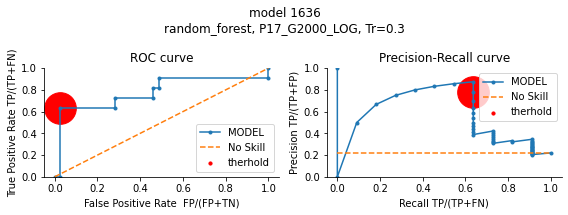

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name   dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None  random_forest  P17_G2000_LOG         0.78  0.88  0.780886  0.636364   

  Presision   F1   tr        counts_y   counts_y_hat  \
0  0.777778  0.7  0.3  {0: 39, 1: 11}  {0: 41, 1: 9}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 6, '...

...............................................................................................
Test Data: tr=0.5: {0: 97, 1: 1}
Test Data: tr=0.3 {0: 73, 1: 25}
...............................................................................................


'Available roc thresholds'

array([0.426, 0.306, 0.259, 0.258, 0.236, 0.231, 0.229, 0.223, 0.152,
       0.144])

-------------------------------------------------------------------------------------------




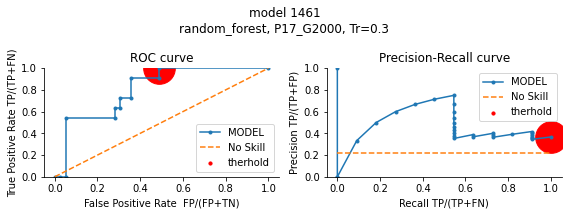

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name dataset_name Acc_baseline   Acc   ROC_AUC Recall  \
0  None  random_forest    P17_G2000         0.78  0.58  0.808858    1.0   

  Presision        F1   tr        counts_y    counts_y_hat  \
0   0.34375  0.511628  0.3  {0: 39, 1: 11}  {0: 18, 1: 32}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 4, '...

...............................................................................................
Test Data: tr=0.5: {0: 97, 1: 1}
Test Data: tr=0.3 {0: 33, 1: 65}
...............................................................................................


'Available roc thresholds'

array([0.447, 0.439, 0.4  , 0.352, 0.351, 0.349, 0.342, 0.337, 0.327,
       0.312, 0.311, 0.171])

-------------------------------------------------------------------------------------------




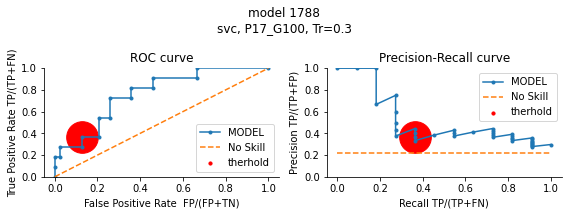

-------------------------------------------------------------------------------------------
Stats - validation data


ID model_name dataset_name Acc_baseline   Acc ROC_AUC    Recall  \
0  None        svc     P17_G100         0.78  0.72  0.7669  0.363636   

  Presision        F1   tr        counts_y    counts_y_hat  \
0  0.363636  0.363636  0.3  {0: 39, 1: 11}  {0: 39, 1: 11}   

                                   model_params  
0  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.3 {0: 69, 1: 29}
...............................................................................................


'Available roc thresholds'

array([0.906, 0.867, 0.781, 0.744, 0.451, 0.442, 0.299, 0.283, 0.26 ,
       0.252, 0.207, 0.206, 0.194, 0.179, 0.111, 0.109, 0.029])

-------------------------------------------------------------------------------------------




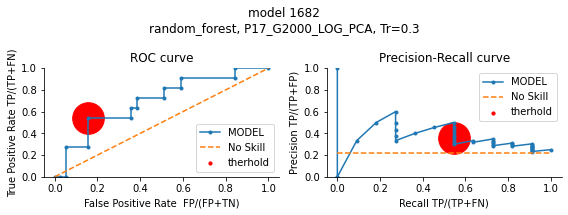

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name       dataset_name Acc_baseline   Acc   ROC_AUC  \
0  None  random_forest  P17_G2000_LOG_PCA         0.78  0.68  0.699301   

     Recall Presision        F1   tr        counts_y    counts_y_hat  \
0  0.545455  0.352941  0.428571  0.3  {0: 39, 1: 11}  {0: 33, 1: 17}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 5, '...

...............................................................................................
Test Data: tr=0.5: {0: 94, 1: 4}
Test Data: tr=0.3 {0: 67, 1: 31}
...............................................................................................


'Available roc thresholds'

array([0.463, 0.44 , 0.417, 0.397, 0.343, 0.288, 0.282, 0.276, 0.27 ,
       0.238, 0.229, 0.214, 0.213, 0.147, 0.127, 0.082])

-------------------------------------------------------------------------------------------




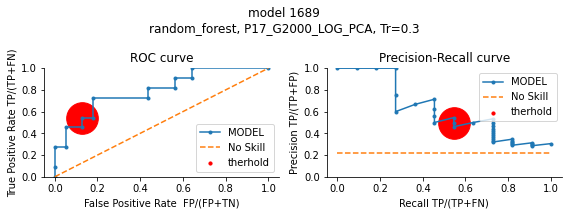

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name       dataset_name Acc_baseline   Acc   ROC_AUC  \
0  None  random_forest  P17_G2000_LOG_PCA         0.78  0.78  0.797203   

     Recall Presision        F1   tr        counts_y    counts_y_hat  \
0  0.545455       0.5  0.521739  0.3  {0: 39, 1: 11}  {0: 38, 1: 12}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 6, '...

...............................................................................................
Test Data: tr=0.5: {0: 98}
Test Data: tr=0.3 {0: 75, 1: 23}
...............................................................................................


'Available roc thresholds'

array([0.398, 0.371, 0.348, 0.339, 0.309, 0.306, 0.3  , 0.28 , 0.242,
       0.239, 0.21 , 0.209, 0.206, 0.205, 0.111])

-------------------------------------------------------------------------------------------




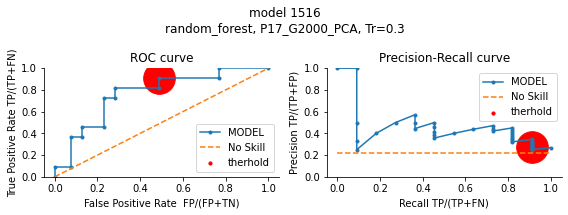

-------------------------------------------------------------------------------------------
Stats - validation data


ID     model_name   dataset_name Acc_baseline   Acc   ROC_AUC    Recall  \
0  None  random_forest  P17_G2000_PCA         0.78  0.44  0.764569  0.909091   

  Presision        F1   tr        counts_y    counts_y_hat  \
0   0.27027  0.416667  0.3  {0: 39, 1: 11}  {0: 13, 1: 37}   

                                        model_params  
0  {'class_weight': 'balanced', 'max_depth': 4, '...

...............................................................................................
Test Data: tr=0.5: {0: 97, 1: 1}
Test Data: tr=0.3 {0: 38, 1: 60}
...............................................................................................


'Available roc thresholds'

array([0.48 , 0.416, 0.38 , 0.376, 0.375, 0.364, 0.354, 0.354, 0.353,
       0.325, 0.325, 0.277, 0.274, 0.216])

-------------------------------------------------------------------------------------------




In [35]:
# PLAY WITH THRESHOLD

for id_nr in top10_models.loc[:,"ID"]:
    
    prediciton_test_adjusted = play_with_rocks(
    ID = id_nr,
    threshold = 0.3,
    predictions_with_y = model_predictions_valid,
    predictions_without_y = model_predictions_test
    )
    

In [37]:
prediciton_test_adjusted

y_hat y_hat_probs  trhreshold
0       0    0.078297         0.5
1       0    0.123569         0.5
2       1    0.729784         0.5
3       0    0.189241         0.5
4       0     0.08679         0.5
..    ...         ...         ...
93      1    0.774282         0.5
94      0    0.189904         0.5
95      0    0.137144         0.5
96      0    0.063577         0.5
97      0    0.410201         0.5

[98 rows x 3 columns]